In [1]:
import networkx as nx
import torch
from torch_geometric.data import Data
import torch_geometric
import numpy as np
from torch_geometric.datasets import CoraFull, CitationFull
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.transforms import ToUndirected
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric.transforms import ToUndirected
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal


%config InlineBackend.figure_format = 'retina'


In [3]:
ADJ_PATH = '/home/udit/Documents/Progyan/results_new_95/Decade_{}-{}.npy'
COORD_PATH = '/home/udit/Documents/Progyan/lat_lon-1901.csv'

In [7]:
graph_list = []

for year in tqdm(range(11, 21, 10)):
    i = 1900 + year
    j = 1909 + year
    adj_matrix = np.load(ADJ_PATH.format(i, j))
    lat_lon_df = pd.read_csv(COORD_PATH)

    adj_matrix = adj_matrix + adj_matrix.transpose()

    ##### REMOVE ######
    adj_matrix = adj_matrix[:4523, :4523]
    ###################

    adj_matrix[adj_matrix < 0.99] = 0
    np.fill_diagonal(adj_matrix, 0)
    G = nx.from_numpy_matrix(adj_matrix)

    lat_lon_dict = {}
    for i in range(len(lat_lon_df)):
        lat_lon_dict[i] = (lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat'])

    nx.set_node_attributes(G, lat_lon_dict, 'pos')
    pos = nx.get_node_attributes(G, 'pos')

    central_nodes = []

    for n in G.nodes:
        if G.nodes[n]['pos'][0] > 74.5 and G.nodes[n]['pos'][0] < 86.5 and G.nodes[n]['pos'][1] > 16.5 and G.nodes[n]['pos'][1] < 26.5:
            central_nodes.append(n)

    G = G.subgraph(central_nodes)

    graph_list.append(G)

100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


0it [00:00, ?it/s]/tmp/ipykernel_1957/152345316.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma')
/tmp/ipykernel_1957/152345316.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_edge = plt.cm.get_cmap('Purples')
1it [00:00,  1.62it/s]


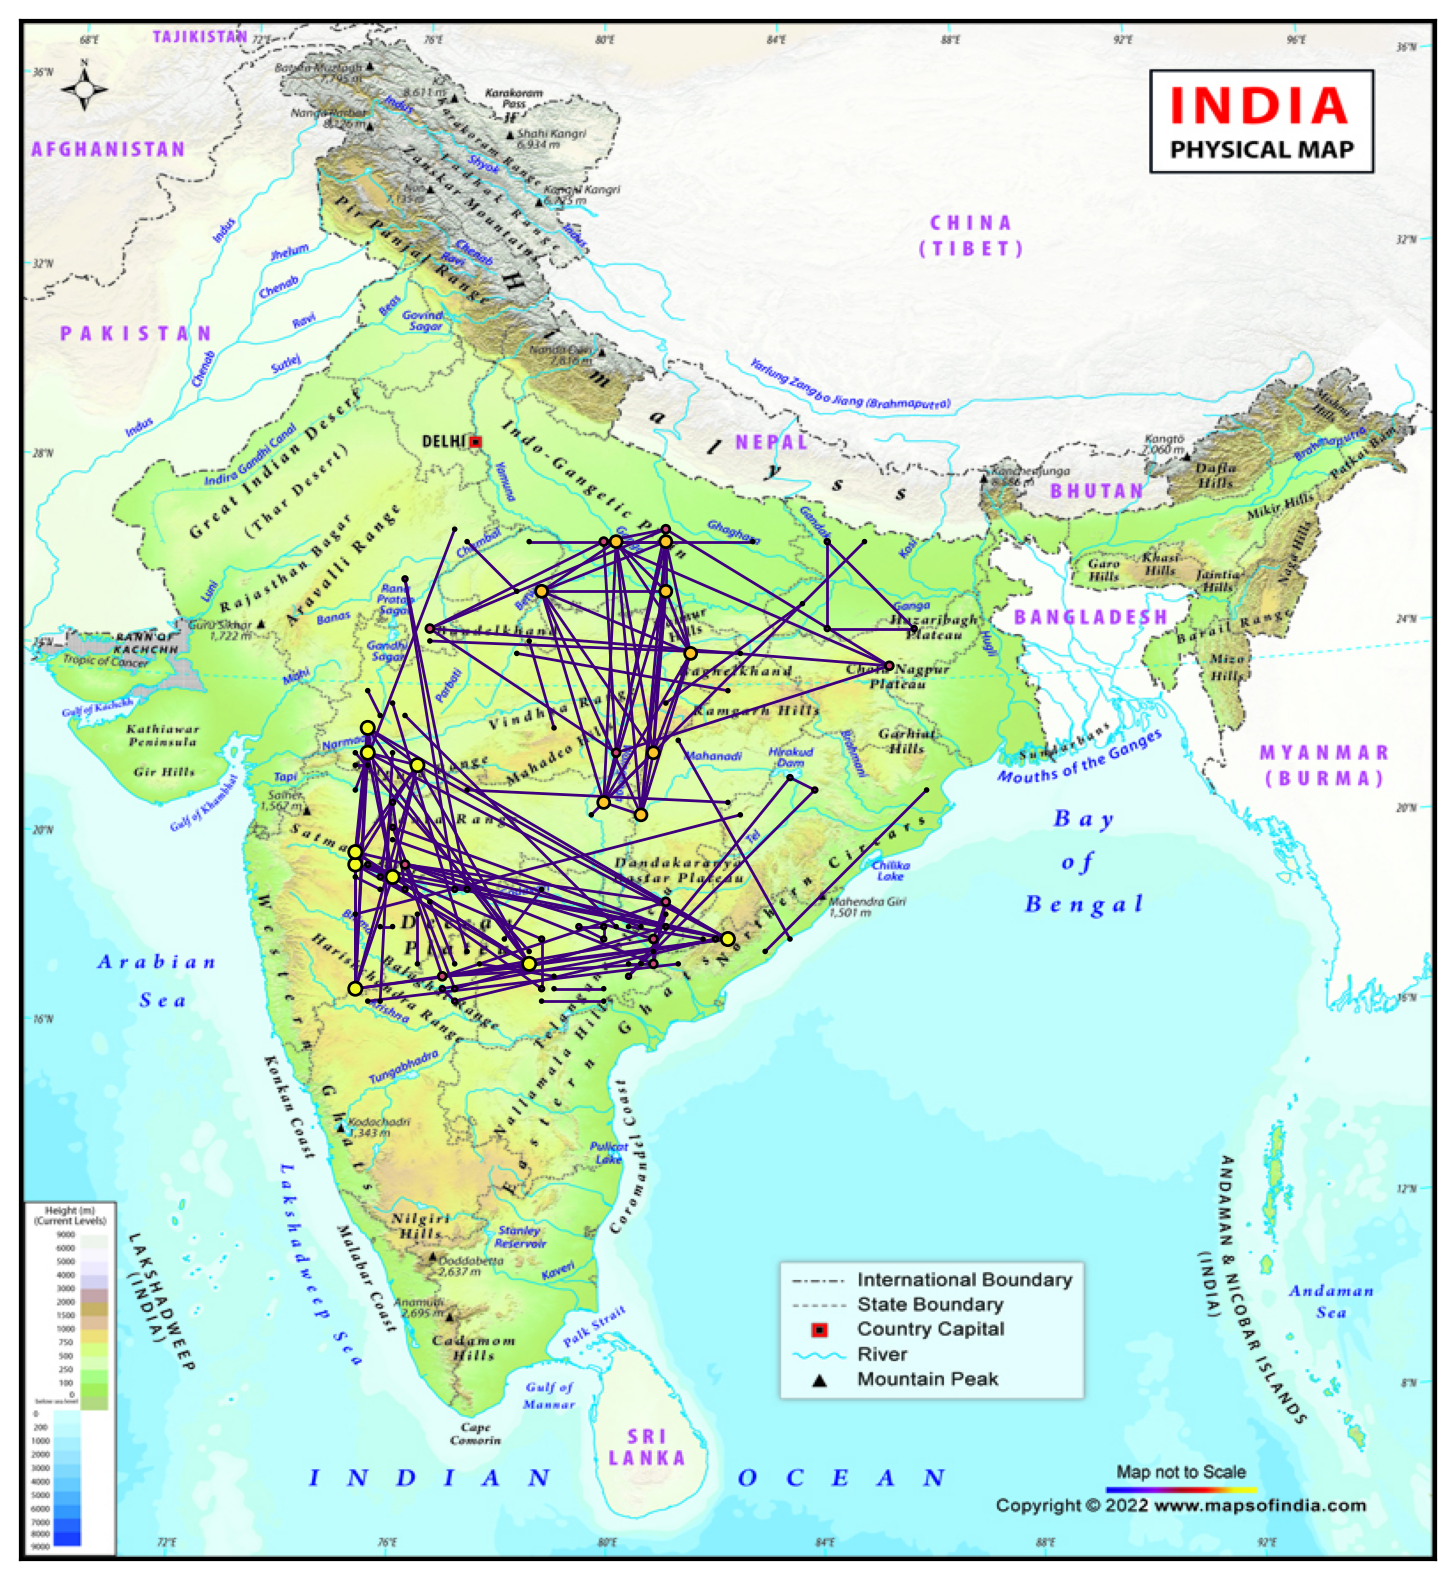

In [13]:
for _, G in tqdm(enumerate(graph_list)):        
    plot = plt.figure(figsize=(10,10))
    india_coords = [[67, 97], [5.5, 38]]
    india_pos = {}

    for node_id, coords in pos.items():
        if coords[1] > 5.5 and coords[1] < 38 and coords[0] > 67 and coords[0] < 97:
            india_pos[node_id] = coords

    d = dict(G.degree)
    degree_dict = dict(G.degree()) 
    degree_values = np.array(list(degree_dict.values())) 

    cmap = plt.cm.get_cmap('plasma')
    cmap_edge = plt.cm.get_cmap('Purples')

    normalized_degrees = (degree_values - degree_values.min()) / (degree_values.max() - degree_values.min())

    node_colors = cmap(normalized_degrees)

    edge_widths = [d['weight'] for (u, v, d) in G.edges(data=True)]
    edge_colors = [d['weight']**3 for (u, v, d) in G.edges(data=True)]

    edge_colors = cmap_edge(edge_colors)

    ################# PLOT NETWORK #####################
    nx.draw_networkx(G, pos = india_pos,
            nodelist=d, 
            width=edge_widths,
            edge_color=edge_colors,
            edgecolors = 'black',
            node_size=[(d[k])**1.5 for k in d],
            with_labels = False,
            node_color=node_colors,)
            
    img = plt.imread('/home/udit/Documents/Progyan/GNN/physical-map-india.jpg')
    plt.imshow(img, extent=[68, 96.5, 5.5, 36.5], alpha=1)
    ######################################################

    save = plt.savefig(f'./temporal_train_graphs/graph{_}.png')

In [97]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [58]:
lat_lon_df = lat_lon_df.iloc[central_nodes]

list_node_features = []
list_edge_list = []
list_target_features = []
list_edge_weights = []

for i, graph in tqdm(enumerate(graph_list)):
    adj_matrix = nx.to_numpy_matrix(graph)

    node_features = []
    for i in lat_lon_df.index:
        node_features.append([lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat']])
    node_features = torch.tensor(node_features, dtype=torch.float)


    edge_list = set()
    edge_weights = []
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if adj_matrix[i, j] > 0:
                append_edge = frozenset({i, j})
                edge_list.add(append_edge)
    edge_list = [tuple(x) for x in list(edge_list)]
    edge_list = np.array(edge_list)
    edge_list = edge_list.transpose()

    central_pos = {}
    for _, i in enumerate(central_nodes):
        central_pos[_] = pos[i]

    transform = ToUndirected()

    list_node_features.append((node_features))
    list_edge_list.append((edge_list))
    list_target_features.append(np.array(torch.randn_like(node_features[:, 0])))
    list_edge_weights.append((  np.array  (np.ones_like(edge_list[0,:]))))

node_features_batch = (list_node_features)
edge_list_batch = (list_edge_list)
target_features_batch = (list_target_features)
edge_weights_batch = (list_edge_weights)


9it [00:41,  4.60s/it]


In [ ]:
edge_weights[0].shape

(1, 422)

In [107]:
dataset = DynamicGraphTemporalSignal(edge_indices= edge_list_batch, edge_weights=edge_weights_batch, features=node_features_batch, targets=target_features_batch)

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

eng_dataset = EnglandCovidDatasetLoader().get_dataset(lags=14)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [119]:
# print(dataset.features[0].shape, eng_dataset.features[0].shape)
print(eng_dataset.edge_weights[3].shape)


(2108,)


In [122]:
from torch_geometric_temporal.nn.recurrent import MPNNLSTM

class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, num_nodes):
        super().__init__()
        self.recurrent = MPNNLSTM(dim_in, dim_h, num_nodes, 1, 0.5)
        self.dropout = torch.nn.Dropout(0.5)
        self.linear = torch.nn.Linear(2*dim_h + dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.dropout(h)
        h = self.linear(h).tanh()
        return h

model = TemporalGNN(dataset[0].x.shape[1], 64, dataset[0].x.shape[0])
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()


TemporalGNN(
  (recurrent): MPNNLSTM(
    (_convolution_1): GCNConv(2, 64)
    (_convolution_2): GCNConv(64, 64)
    (_batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_recurrent_1): LSTM(128, 64)
    (_recurrent_2): LSTM(64, 64)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=130, out_features=1, bias=True)
)


TemporalGNN(
  (recurrent): MPNNLSTM(
    (_convolution_1): GCNConv(2, 64)
    (_convolution_2): GCNConv(64, 64)
    (_batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_recurrent_1): LSTM(128, 64)
    (_recurrent_2): LSTM(64, 64)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=130, out_features=1, bias=True)
)

Text(0, 0.5, 'Mean normalized number of cases')

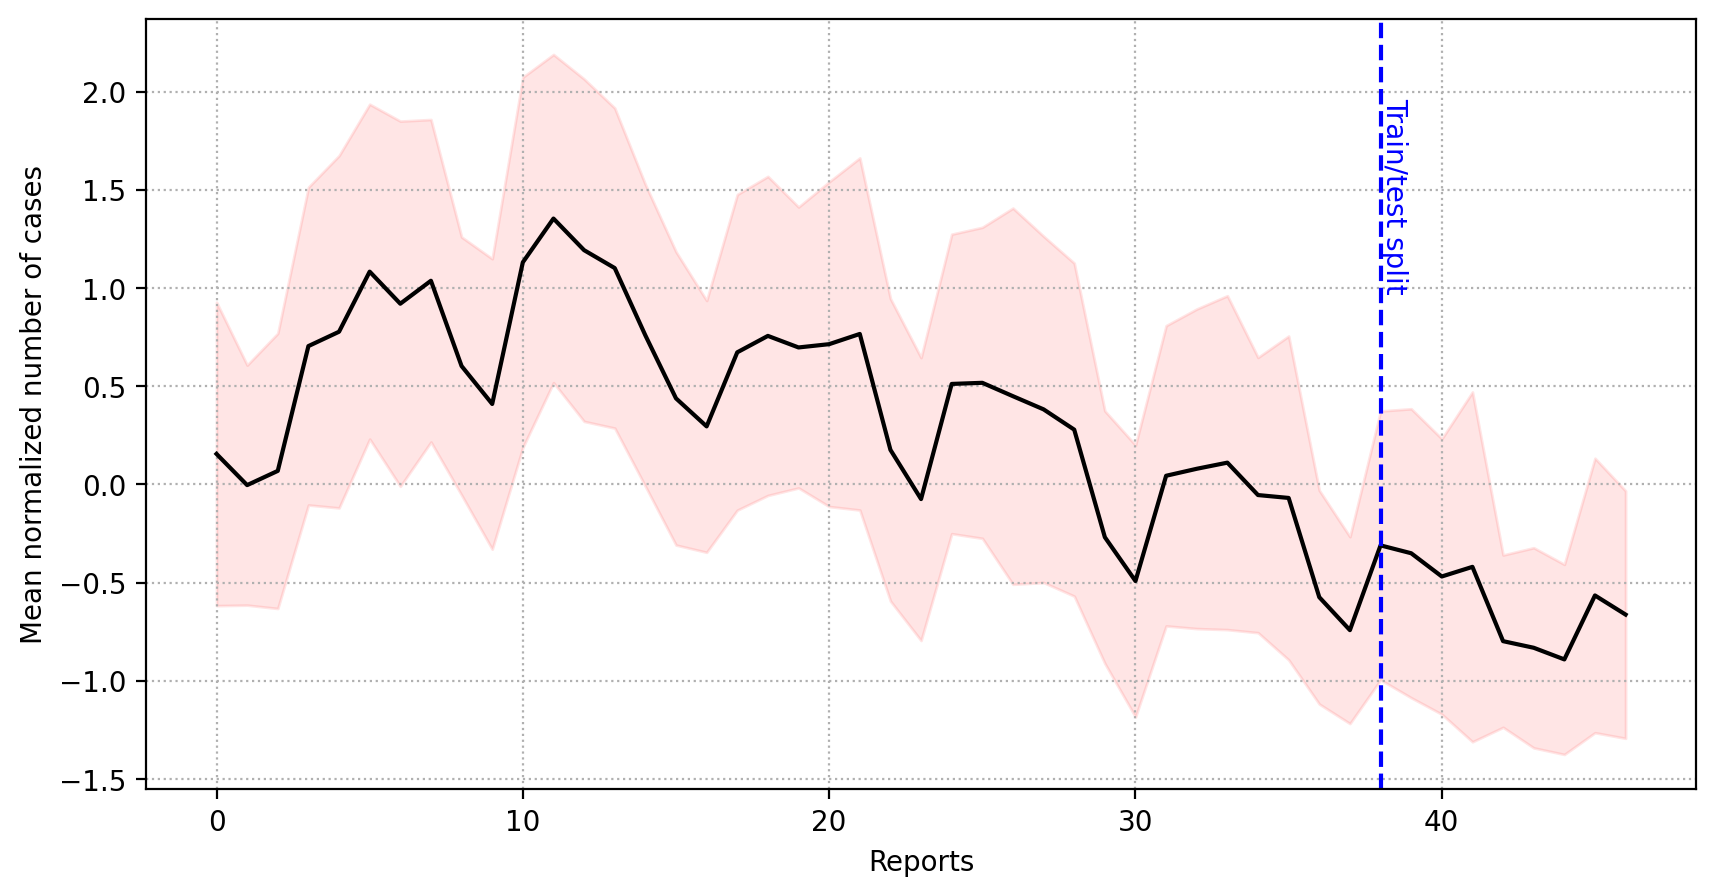

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

dataset = EnglandCovidDatasetLoader().get_dataset(lags=14)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
                         
plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Reports')
plt.ylabel('Mean normalized number of cases')

In [124]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [132]:
model = model.to("cuda:0")

AttributeError: 'DynamicGraphTemporalSignal' object has no attribute 'to'

In [137]:
for epoch in tqdm(range(100)):
    loss = 0
    for i, snapshot in enumerate(train_dataset):
        snapshot = snapshot.to("cuda:0")
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = loss + torch.mean((y_pred - snapshot.y)**2)
        print(loss)
    loss = loss / (i+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/100 [00:00<?, ?it/s]

tensor(1.3817, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8853, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3232, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.7992, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.2901, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.8112, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.3167, device='cuda:0', grad_fn=<AddBackward0>)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:

# Evaluation
model.eval()
loss = 0
for i, snapshot in enumerate(val_dataset):
    snapshot = snapshot.to(device)
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE: {loss.item():.4f}')

In [60]:
from torch_geometric_temporal.dataset import TwitterTennisDatasetLoader

In [53]:
ah = TwitterTennisDatasetLoader()
a = ah.get_dataset()

In [82]:
a.edge_indices[10]

array([[934, 934,   4, 830,  72,  92, 392, 495, 495, 495, 234, 117,  64,
          4, 610, 610, 200, 200, 200,   0, 587, 587, 587, 587, 587, 517,
        666,  68,  68,  68,  68,  68, 587, 587, 773, 773, 973, 136, 214,
        214, 197, 197, 451, 587, 587,  68,  35,  35,  35,  35,  35,   0,
          0,   0,   0,  35,   0,   0, 587, 587, 594, 302, 302, 722, 722,
        722, 722, 587, 587, 587, 302, 693, 302, 144, 650, 543, 117,  38,
        298, 298,  38, 238, 238, 831, 831, 831, 156, 156, 156, 156, 156,
        156, 156, 187, 243, 243, 243, 488, 488, 243, 187, 391, 391,   9,
         10, 422, 422, 422, 422, 383, 383, 383, 383, 383, 884, 884,  40,
         40,  40, 309, 309, 309, 582, 489, 489, 489, 489],
       [  0, 417,   0,  42,   0,  92, 144,  97,   0,   1,   0,   0,   0,
          1,   0,   4,   9,   0, 386,  31, 628,   4,  80,   0, 170,   7,
          0, 293, 762,   0,   5, 918, 443, 251,   1,   0,   0,   0,  62,
          0,   0,   8, 917, 269,  98,  59,  48, 268, 208,  57, 58

In [84]:
train_dataset = a

In [85]:
train_loader, val_loader = temporal_signal_split(train_dataset,
                                                 train_ratio=0.2)

In [86]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = TGCN(node_features, 32)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, prev_hidden_state):
        h = self.recurrent(x, edge_index, edge_weight, prev_hidden_state)
        y = F.relu(h)
        y = self.linear(y)
        return y, h
        
model = RecurrentGCN(node_features = 2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(10)):
    cost = 0
    hidden_state = None
    for time, snapshot in enumerate(train_loader):
        y_hat, hidden_state = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr,hidden_state)
        cost = cost + torch.mean((y_hat-snapshot.y)**2).cpu()
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    
model.eval()
cost = 0
hidden_state = None
for time, snapshot in enumerate(train_dataset):
    y_hat, hidden_state = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, hidden_state)
    cost = cost + torch.mean((y_hat-snapshot.y)**2).cpu()
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x16 and 2x32)

In [27]:
edge_list_batch

AttributeError: 'list' object has no attribute 'shape'